In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# ---------------------------
# 1. Load and Preprocess Data
# ---------------------------

# Load data
df = pd.read_excel('Data_GHGE.xlsx')

# Feature selection
feature_columns = [
    'FP index ', 'LP index ', 'Vegetal Pds-FS', 'Cereals -FS', 'Starchy Rts-FS',
    'Pulses-FS', 'Fruits -FS', 'Meat-FS', 'Fish-FS', 'Sugar & Swt-FS', 
    'Oils-FS ', 'Vegetables-FS ', 'Spices-FS', 'Eggs-FS', 'Milk-FS',
    'Cereals-LSF', 'Starchy Rts-LSF', 'Pulses-LSF', 'Meat-LSF', 'Fish-LSF',
    'Cereals-LS', 'Starchy-LS', 'Fruits-LS', 'Energy use', 'Renewable energy '
]

df.columns

Index(['Indicator Code', 'FP index ', 'LP index ', 'Vegetal Pds-FS',
       'Cereals -FS', 'Starchy Rts-FS', 'Pulses-FS', 'Fruits -FS', 'Meat-FS',
       'Fish-FS', 'Sugar & Swt-FS', 'Oils-FS ', 'Vegetables-FS ', 'Spices-FS',
       'Eggs-FS', 'Milk-FS', 'Cereals-LSF', 'Starchy Rts-LSF', 'Pulses-LSF',
       'Meat-LSF', 'Fish-LSF', 'Cereals-LS', 'Starchy-LS', 'Fruits-LS',
       'Energy use', 'Renewable energy ', 'GHGEs ',
       'Agricultural land use share ', 'Agricultural water share ',
       'Surface temp.', 'Overweight', 'Obese', 'Death-NCD ',
       'Life expectancy '],
      dtype='object')

In [3]:
X = df[feature_columns].values
y = df[ 'Life expectancy '].values 

# Split data before scaling to prevent data leakage
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.15, random_state=42,
    stratify=pd.qcut(y, q=5, labels=False)
)


# Initialize scalers
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

In [4]:
# Fit scalers on training data
X_train_scaled = feature_scaler.fit_transform(X_train_raw)
y_train_scaled = target_scaler.fit_transform(y_train_raw.reshape(-1, 1))

# Transform test data
X_test_scaled = feature_scaler.transform(X_test_raw)
y_test_scaled = target_scaler.transform(y_test_raw.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, sequence_length=3):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length + 1):
        sequences_X.append(X[i:i+sequence_length])
        sequences_y.append(y[i+sequence_length-1])
    return np.array(sequences_X), np.array(sequences_y)

# Create sequences in training data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length=3)

# Create sequences in test data
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length=3)

In [5]:
# 2. Build the Bidirectional LSTM Model
# ---------------------------

from tensorflow.keras.layers import Bidirectional

# Build the model
model = Sequential([
    LSTM(100, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True, 
         kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    LSTM(100, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='linear')
])

C:\Users\Prince\Anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
#  Define custom metric
def correlation_coefficient(y_true, y_pred):
    x = y_true - K.mean(y_true)
    y = y_pred - K.mean(y_pred)
    numerator = K.sum(x * y)
    denominator = K.sqrt(K.sum(K.square(x)) * K.sum(K.square(y)))
    return numerator / (denominator + K.epsilon())

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', correlation_coefficient]
)


In [7]:
# 4. Train the Model
# ---------------------------

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_correlation_coefficient', mode='max', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
]

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - correlation_coefficient: -0.0326 - loss: 0.6398 - mae: 0.5407 - val_correlation_coefficient: 0.4639 - val_loss: 0.5931 - val_mae: 0.4996 - learning_rate: 0.0010
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - correlation_coefficient: 0.0943 - loss: 0.6160 - mae: 0.5347 - val_correlation_coefficient: 0.5899 - val_loss: 0.5720 - val_mae: 0.4946 - learning_rate: 0.0010
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - correlation_coefficient: 0.4391 - loss: 0.5845 - mae: 0.5259 - val_correlation_coefficient: 0.6320 - val_loss: 0.5498 - val_mae: 0.4853 - learning_rate: 0.0010
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - correlation_coefficient: 0.4467 - loss: 0.5729 - mae: 0.5265 - val_correlation_coefficient: 0.7044 - val_loss: 0.5272 - val_mae: 0.4760 - learning_rate: 0.0010
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - correlation_coefficient: 0.5226 - loss: 0.5556 - mae: 0.5176 - val_correlation_coefficient: 0.7419 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - correlation_coefficient: 0.8736 - loss: 0.1121 - mae: 0.1352 - val_correlation_coefficient: 0.9480 - val_loss: 0.1220 - val_mae: 0.1618 - learning_rate: 0.0010
Epoch 35/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - correlation_coefficient: 0.8784 - loss: 0.1047 - mae: 0.1079 - val_correlation_coefficient: 0.9507 - val_loss: 0.1198 - val_mae: 0.1496 - learning_rate: 0.0010
Epoch 36/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - correlation_coefficient: 0.8849 - loss: 0.1001 - mae: 0.1090 - val_correlation_coefficient: 0.9532 - val_loss: 0.1175 - val_mae: 0.1472 - learning_rate: 0.0010
Epoch 37/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - correlation_coefficient: 0.8778 - loss: 0.1053 - mae: 0.1248 - val_correlation_coefficient: 0.9528 - val_loss: 0.1161 - val_mae: 0.1450 - learning_rate: 0.0010
Epoch 38/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - correlation_coefficient: 0.8769 - loss: 0.1018 - mae: 0.1157 - val_correlation_coefficient: 0.9511 - val_loss: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - correlation_coefficient: 0.8914 - loss: 0.0671 - mae: 0.0788 - val_correlation_coefficient: 0.9706 - val_loss: 0.0792 - val_mae: 0.1344 - learning_rate: 0.0010
Epoch 68/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - correlation_coefficient: 0.8891 - loss: 0.0679 - mae: 0.0795 - val_correlation_coefficient: 0.9690 - val_loss: 0.0797 - val_mae: 0.1328 - learning_rate: 0.0010
Epoch 69/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - correlation_coefficient: 0.8872 - loss: 0.0699 - mae: 0.0890 - val_correlation_coefficient: 0.9698 - val_loss: 0.0792 - val_mae: 0.1270 - learning_rate: 0.0010
Epoch 70/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - correlation_coefficient: 0.8866 - loss: 0.0687 - mae: 0.0877 - val_correlation_coefficient: 0.9730 - val_loss: 0.0764 - val_mae: 0.1172 - learning_rate: 0.0010
Epoch 71/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - correlation_coefficient: 0.8897 - loss: 0.0647 - mae: 0.0784 - val_correlation_coefficient: 0.9775 - val_los

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - correlation_coefficient: 0.8868 - loss: 0.0536 - mae: 0.0841 - val_correlation_coefficient: 0.9826 - val_loss: 0.0545 - val_mae: 0.1003 - learning_rate: 0.0010
Epoch 101/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - correlation_coefficient: 0.8928 - loss: 0.0485 - mae: 0.0715 - val_correlation_coefficient: 0.9806 - val_loss: 0.0556 - val_mae: 0.1090 - learning_rate: 0.0010
Epoch 102/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - correlation_coefficient: 0.8902 - loss: 0.0537 - mae: 0.0913 - val_correlation_coefficient: 0.9815 - val_loss: 0.0545 - val_mae: 0.1046 - learning_rate: 0.0010
Epoch 103/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - correlation_coefficient: 0.8937 - loss: 0.0490 - mae: 0.0728 - val_correlation_coefficient: 0.9840 - val_loss: 0.0547 - val_mae: 0.0990 - learning_rate: 0.0010
Epoch 104/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - correlation_coefficient: 0.8917 - loss: 0.0489 - mae: 0.0750 - val_correlation_coefficient: 0.9848 - val

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - correlation_coefficient: 0.8948 - loss: 0.0363 - mae: 0.0507 - val_correlation_coefficient: 0.9882 - val_loss: 0.0405 - val_mae: 0.0783 - learning_rate: 0.0010
Epoch 134/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - correlation_coefficient: 0.8916 - loss: 0.0417 - mae: 0.0829 - val_correlation_coefficient: 0.9895 - val_loss: 0.0404 - val_mae: 0.0774 - learning_rate: 0.0010
Epoch 135/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - correlation_coefficient: 0.8944 - loss: 0.0384 - mae: 0.0656 - val_correlation_coefficient: 0.9901 - val_loss: 0.0451 - val_mae: 0.0925 - learning_rate: 0.0010
Epoch 136/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - correlation_coefficient: 0.8935 - loss: 0.0420 - mae: 0.0802 - val_correlation_coefficient: 0.9888 - val_loss: 0.0451 - val_mae: 0.0939 - learning_rate: 0.0010
Epoch 137/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - correlation_coefficient: 0.8938 - loss: 0.0366 - mae: 0.0576 - val_correlation_coefficient: 0.9875 - val

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - correlation_coefficient: 0.8948 - loss: 0.0292 - mae: 0.0486 - val_correlation_coefficient: 0.9923 - val_loss: 0.0337 - val_mae: 0.0788 - learning_rate: 0.0010
Epoch 167/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - correlation_coefficient: 0.8938 - loss: 0.0325 - mae: 0.0685 - val_correlation_coefficient: 0.9926 - val_loss: 0.0324 - val_mae: 0.0739 - learning_rate: 0.0010
Epoch 168/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - correlation_coefficient: 0.8929 - loss: 0.0318 - mae: 0.0688 - val_correlation_coefficient: 0.9922 - val_loss: 0.0307 - val_mae: 0.0696 - learning_rate: 0.0010
Epoch 169/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - correlation_coefficient: 0.8902 - loss: 0.0340 - mae: 0.0807 - val_correlation_coefficient: 0.9918 - val_loss: 0.0305 - val_mae: 0.0705 - learning_rate: 0.0010
Epoch 170/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - correlation_coefficient: 0.8931 - loss: 0.0322 - mae: 0.0657 - val_correlation_coefficient: 0.9907 - val

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - correlation_coefficient: 0.8952 - loss: 0.0253 - mae: 0.0543 - val_correlation_coefficient: 0.9889 - val_loss: 0.0295 - val_mae: 0.0811 - learning_rate: 0.0010
Epoch 200/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - correlation_coefficient: 0.8943 - loss: 0.0253 - mae: 0.0597 - val_correlation_coefficient: 0.9904 - val_loss: 0.0286 - val_mae: 0.0755 - learning_rate: 0.0010


In [8]:
# Evaluate the model
y_pred_scaled = model.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = target_scaler.inverse_transform(y_test_seq)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

r2 = r2_score(y_test_unscaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
mae = mean_absolute_error(y_test_unscaled, y_pred)
rmae= np.sqrt(mean_absolute_error(y_test_unscaled, y_pred))
corr_coef = np.corrcoef(y_test_unscaled.flatten(), y_pred.flatten())[0,1]

print("\nTest Metrics:")
print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMAE:{rmae:.4f}")

print(f"\nPrediction Range:")
print(f"Min: {y_pred.min():.4f}, Max: {y_pred.max():.4f}")

print(f"\nCorrelation coefficient: {corr_coef:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step

Test Metrics:
R2: 0.9777
RMSE: 0.4386
MAE: 0.3356
RMAE:0.5793

Prediction Range:
Min: 70.4495, Max: 78.1236

Correlation coefficient: 0.9936


# Training and validation loss

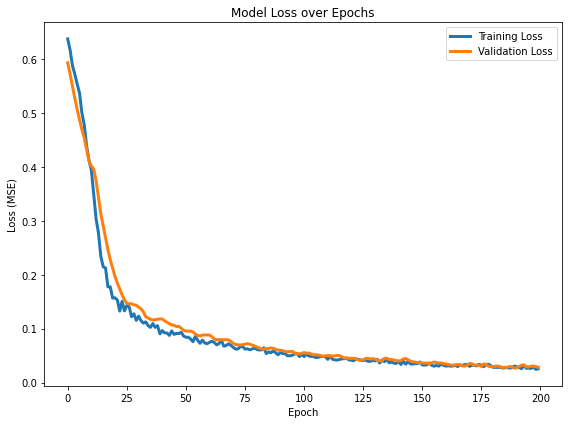

In [9]:
# Plot training & validation loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=3)
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
# plt.savefig('figures/training_validation_loss.png')
plt.show()

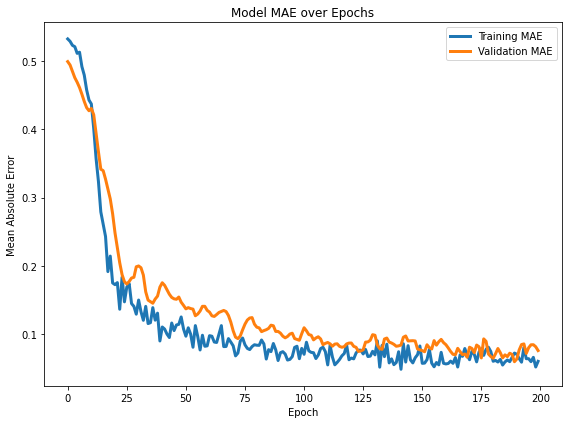

In [10]:
# Plot training & validation MAE
plt.figure(figsize=(8,6))
plt.plot(history.history['mae'], label='Training MAE', linewidth=3)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=3)
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
# plt.savefig('figures/training_validation_mae.png')
plt.show()

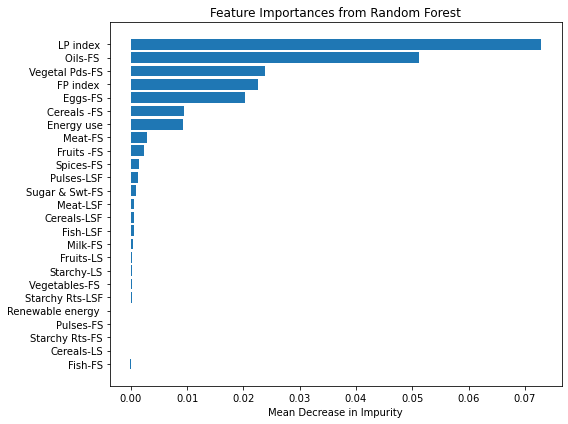

In [11]:
# 8. Additional Visualizations
# ---------------------------

# Feature Importance using Permutation Importance (Optional)
from sklearn.inspection import permutation_importance

# Since LSTM models are not directly compatible with permutation importance,
# we'll use a simple approximation by training a Random Forest as a surrogate model.

from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest on the scaled training data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_scaled.ravel())

# Compute permutation importance on the test data
perm_importance = permutation_importance(rf, X_test_scaled, y_test_scaled.ravel(), n_repeats=10, random_state=42)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Plot Feature Importances
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(8,6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_columns)[sorted_idx])
plt.title('Feature Importances from Random Forest')
plt.xlabel('Mean Decrease in Impurity')
plt.tight_layout()
# plt.savefig('figures/feature_importances.png')
plt.show()

# Save the feature importances to a CSV file
feature_importance_df = pd.DataFrame({
    'Feature': np.array(feature_columns)[sorted_idx],
    'Importance': feature_importances[sorted_idx]
})
# feature_importance_df.to_csv('figures/feature_importances.csv', index=False)


In [12]:
# # Save the scalers
# os.makedirs('models', exist_ok=True)
# joblib.dump(feature_scaler, 'scaler.pkl')
# joblib.dump(target_scaler, 'models/target_scaler.save')

# # Save the model
# model.save('models/lstm_life_expectancy.h5')

# Importing the saved model for prediction